## How to add Pauses into the Blocklist
(this method does not simulate a true "pause" at the selected point: the toolhead will not necessarily come to a full stop)
1. First we need to define all input parameters for the simulation as usual

In [16]:
%matplotlib widget
from pyGCodeDecode import gcode_interpreter
from pyGCodeDecode import planner_block
anisoprint_A4 = {
    #general properties
    "nozzle_diam"   :   0.4,
    "filament_diam" :   1.75,
    
    #default settings
    "velocity"      :   35,
    "acceleration"  :   1000,
    "jerk"          :   10,
    
    #axis max speeds
    "Vx"            :   180,
    "Vy"            :   180,
    "Vz"            :   30,
    "Ve"            :   33
    }

""" INITIAL POSITION:
    None        -> start from zero
    True        -> use first gcode G1 command as initial position
    [x,y,z,e]   -> non zero coordinates for initial position
"""
initial_position = None

# simulation = gcode_interpreter.simulate(filename=r"assembly_cake_20220831.gcode",printer=anisoprint_A4,initial_position=initial_position)
simulation = gcode_interpreter.simulate(filename=r"test.gcode",printer=anisoprint_A4,initial_position=initial_position)

[##########] 100% of Planner Block Generation Done...
 >> pyGCodeDecode extracted 7 states from test.gcode and generated 6 plannerblocks.
 
            Estimated time to travel all states with provided printer settings is 1.8682817772582736 seconds.


2. Then we want to split the blocklist in seperate parts to apply the timeshift method on certain blocks. Since we dont know beforehand which block in the blocklist will be at the required point in the GCODE, we can either search through the list for a certain GCODE line number or a certain height. (height might result in problems due to z-hop on previous layers)

In [17]:
# [block.state_A.line_nmbr for block in blocklist if block.state_A.line_nmbr > 47601]
# [block.state_A.line_nmbr for block in blocklist if block.state_A.state_position.z >= 22.3]

### Lets look at the velplot before the adjustment

[##########] 100% of Velocity Plot Done...


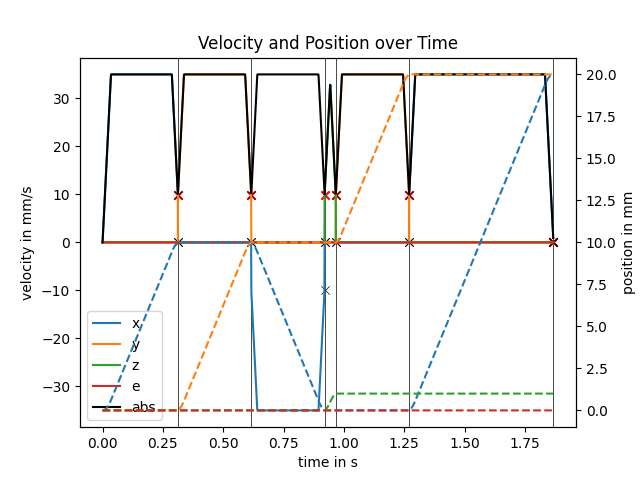

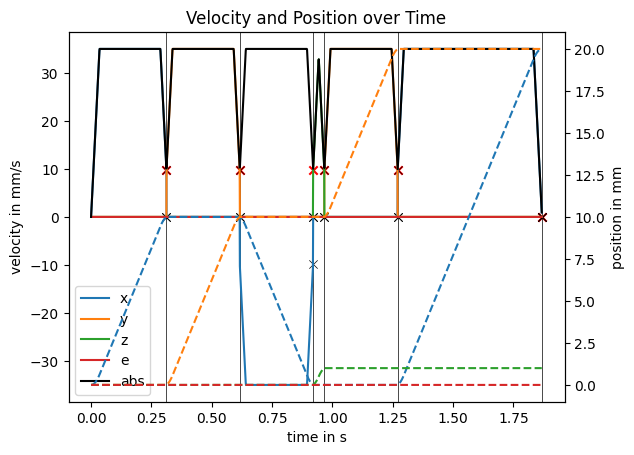

In [18]:
simulation.plot_vel(filename=False,show=True,timesteps=2000)

3. Here z-height is used: therefore we define a z split height

In [19]:
z_split = 1 # split height, where blocklist will be split

In [20]:
blocklist = simulation.blocklist
blocklist_split0 = [block for block in blocklist if block.state_A.state_position.z < z_split]
blocklist_split1 = [block for block in blocklist if block.state_A.state_position.z >= z_split]
for block in blocklist_split1: print(block.segments[0].t_begin)

0.9664810566563625
1.2703005846766842


4. This is where we apply the timeshift to the second half of the blocklist

In [21]:
for block in blocklist_split1: block.timeshift(5)

lets see the before and after

In [22]:
for block in blocklist_split1: print(block.segments[0].t_begin)

5.966481056656362
6.270300584676685


5. so now lets overwrite the existing blocklist of the simulation so we can use class functions such as plot_vel()

In [23]:
new_blocklist = list()
new_blocklist.extend(blocklist_split0)
new_blocklist.extend(blocklist_split1)

simulation.blocklist = new_blocklist

let's see the changed timing in the velocity plot

[##########] 100% of Velocity Plot Done...


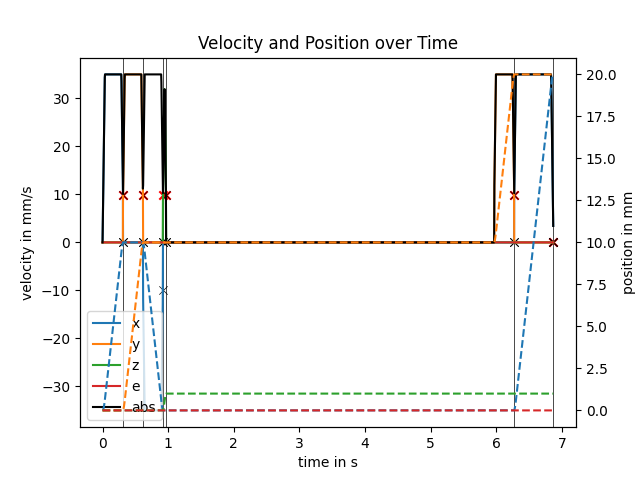

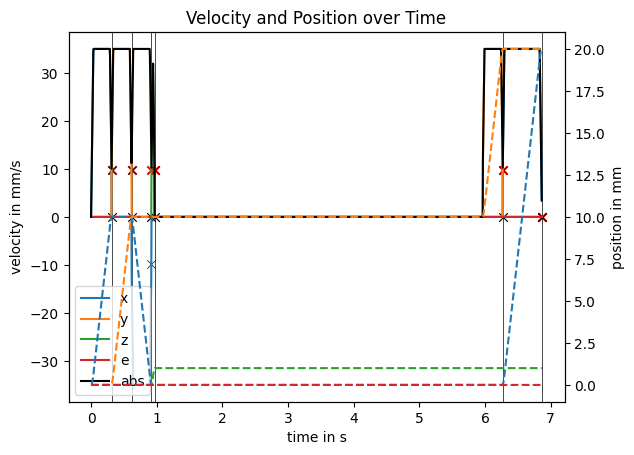

In [24]:
simulation.plot_vel(filename=False,show=True,timesteps=2000)

6. Finally: let's generate the Abaqus INP file

In [25]:
from pyGCodeDecode import abaqus_file_generator

In [26]:
abaqus_file_generator.generate_abaqus_events(simulation,output_filename=simulation.filename[:-6]+"-abaqus.inp")

# Done